<a href="https://colab.research.google.com/github/fellowship/touch-up-the-hair/blob/main/touch_up_the_hair_experiementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install  libraries

In [1]:
!pip install mediapipe
!pip install --upgrade diffusers[torch]
!pip install transformers
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers
!pip install -qU controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

# Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create require directories

In [3]:
import os
import logging
from pathlib import Path
project_dir_path = '/content/drive/MyDrive/touch-up-the-hair'
mask_dir_path = 'output_dir/masks'
touched_dir_path = 'output_dir/touched'
restored_dir_path = 'output_dir/touched_and_restored'
directory_list = ['models', 'input_dir', mask_dir_path, touched_dir_path, restored_dir_path]
for directory in directory_list:
    directory_path = os.path.join(project_dir_path, directory)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

In [4]:
import urllib.request
selfie_multiclass_model_path = os.path.join(project_dir_path, "models", "selfie_multiclass_256x256.tflite")
selfie_multiclass_model_url = "https://storage.googleapis.com/mediapipe-models/image_segmenter/selfie_multiclass_256x256/float32/latest/selfie_multiclass_256x256.tflite"
if(not os.path.exists(selfie_multiclass_model_path)):
  # Download the model
  urllib.request.urlretrieve(selfie_multiclass_model_url,selfie_multiclass_model_path)

# Clone CodeFormer

In [5]:
# Clone CodeFormer and enter the CodeFormer folder
%cd /content/
!rm -rf CodeFormer
!git clone https://github.com/sczhou/CodeFormer.git
%cd CodeFormer

# Set up the environment
# Install python dependencies
!pip install -r requirements.txt
# Install basicsr
!python basicsr/setup.py develop

# Download the pre-trained model
!python scripts/download_pretrained_models.py facelib
!python scripts/download_pretrained_models.py CodeFormer
%cd /content/

/content
Cloning into 'CodeFormer'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (594/594), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 594 (delta 288), reused 491 (delta 268), pack-reused 0
Receiving objects: 100% (594/594), 17.31 MiB | 19.33 MiB/s, done.
Resolving deltas: 100% (288/288), done.
/content/CodeFormer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.1 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.

In [6]:
def face_restoration(image_in):
    %cd /content/CodeFormer/
    upload_folder = 'inputs/user_upload'
    if os.path.isdir(upload_folder):
        shutil.rmtree(upload_folder)
    os.mkdir(upload_folder)
    image_in.save(os.path.join(upload_folder,'image.png'))

    # We set w to 0.7 for the whole images
    # you can add '--bg_upsampler realesrgan' to enhance the background
    #@markdown *Codeformer_Fidelity (0 for better quality, 1 for better identity)*
    CODEFORMER_FEDILITY = 0.7 # @param {type:"slider", min:0, max:1, step:0.05}
    !python inference_codeformer.py -w $CODEFORMER_FEDILITY --input_path inputs/user_upload --bg_upsampler realesrgan
    %cd /content/
    img_out = Image.open(f'/content/CodeFormer/results/user_upload_{CODEFORMER_FEDILITY}/final_results/image.png')
    return img_out


# Import libraries

In [7]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import math
import numpy as np
from PIL import Image
from numpy import float32
import matplotlib.pyplot as plt
import requests
import torch
import PIL
from diffusers import ControlNetModel, StableDiffusionControlNetInpaintPipeline, DPMSolverMultistepScheduler,UniPCMultistepScheduler,EulerDiscreteScheduler
from diffusers.utils import load_image
import torch
from google.colab import userdata
import io
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import os
import shutil

In [15]:
#@markdown # **Generate Class**
class GenerateMask(object):

    def __init__(self, image_path):

        self._image_BGR = cv2.imread(image_path)
        if self._image_BGR is None:
            raise ValueError(f"Failed to load image from path: {image_path}")

        # Convert image to RGB (OpenCV uses BGR by default)
        self._image_RGB = cv2.cvtColor(self._image_BGR, cv2.COLOR_BGR2RGB)

        # Model path
        self._HAIR_SEGMENTER_MODEL_PATH = "/content/drive/MyDrive/models/selfie_multiclass_256x256.tflite"

        # Create the options for ImageSegmenter
        base_options = python.BaseOptions(model_asset_path = self._HAIR_SEGMENTER_MODEL_PATH)
        self._options = vision.ImageSegmenterOptions(base_options = base_options, output_category_mask = True)

        self.MASK_COLOR = (255, 255, 255)  # Define MASK_COLOR
        self.BG_COLOR = (0, 0, 0)  # Define BG_COLOR

    def get_image_BGR(self):
        """
            return image_BGR
        """
        return self._image_BGR

    def get_image_RGB(self):
        """
            return image_RGB
        """
        return self._image_RGB


    def get_mask(self,CLASS_INDEX = 1):
        """
            Get the hair mask using Mediapipe's ImageSegmenter.
        Returns:
            - np.array: Hair mask image.
        """

        # Convert the image to Mediapipe's format
        image_mediapipe = mp.Image(image_format = mp.ImageFormat.SRGB, data = self._image_BGR)

        # Retrieve the masks for the segmented image
        with vision.ImageSegmenter.create_from_options(self._options) as segmenter:
            segmentation_result = segmenter.segment(image_mediapipe)
            category_mask = segmentation_result.category_mask.numpy_view()

            mask_image = np.zeros(self._image_BGR.shape, dtype = np.uint8)
            bg_image = mask_image.copy()
            mask_image[:] = self.MASK_COLOR
            bg_image[:] = self.BG_COLOR

            # Generate hair mask
            condition = np.stack((category_mask,) * 3, axis = -1) == CLASS_INDEX
            mask = np.where(condition, mask_image, bg_image)

            return mask

    def get_hair_mask(self):
        return self.get_mask()

    def get_face_mask(self):
        return self.get_mask(CLASS_INDEX = 3)


    def get_gray_mask(self,mask_path = None):

        if mask_path is None:
            # If hair_mask_path is not available, calculate hair mask on the fly
            mask = self.get_hair_mask()
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        else:
            # Load the binary mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        return mask

    def get_minority_hair_mask(self, mask_path = None, num_cluster = 2, model = "KMeans", majority=False):
        """
        Generate a hair minority mask based on the input image and its corresponding mask.

        Parameters:
        - image_path (str): Path to the input image.
        - mask_path (str): Path to the binary mask where hair regions are white and background is black.
        - num_cluster (int): Number of clusters for KMeans clustering (default is 3).
        - model (str): Model to use for clustering (default is "KMeans").
        - majority (bool): Whether to use the majority cluster (default is False).
        Returns:
        - np.array: Hair minority mask image.
        """

        mask = self.get_gray_mask(mask_path = mask_path)

        #Perform K-means clustering solely on hair pixels,
        #creating two clusters instead of analyzing the entire image with three clusters.
        #This approach is chosen to avoid potential clustering of
        #dark black hair with the background due to similar color tones.
        #Subsequently, identify non-zero pixels within the mask, representing the masked area.
        mask_indices = np.where(mask > 0)

        # Get the pixels within the masked area
        pixels = self._image_RGB[mask_indices].reshape((-1, 3))

        # Perform KMeans clustering on the pixels
        if model == "KMeans":
          model = KMeans(n_clusters = num_cluster, n_init = 10)
        elif model == "GaussianMixture":
          model = GaussianMixture(n_components = num_cluster, covariance_type = 'full')
        else:
          raise ValueError("Invalid model name. Valid options are 'KMeans' and 'GaussianMixture'.")

        model.fit(pixels)

        # Get the labels for each pixel
        labels = model.predict(pixels)

        # Find the cluster with the fewest pixels
        if majority == False:
          min_cluster_label = np.bincount(labels).argmin()
        else:
          min_cluster_label = np.bincount(labels).argmax()

        # Create a binary mask where pixels belonging to the minimum cluster class are white
        cluster_mask = np.zeros_like(mask)
        cluster_mask[mask_indices] = 255 * (labels == min_cluster_label)

        rgb_img_hair_minority_mask = cv2.cvtColor(cluster_mask, cv2.COLOR_BGR2RGB)

        return rgb_img_hair_minority_mask


    def get_gray_minority_mask(self, minority_mask_path = None):
        if minority_mask_path is None:
            # If hair_mask_path is not available, calculate hair mask on the fly
            minority_mask = self.get_minority_hair_mask()
            minority_mask = cv2.cvtColor(minority_mask, cv2.COLOR_BGR2GRAY)
        else:
            # Load the binary mask
            minority_mask = cv2.imread(minority_mask_path, cv2.IMREAD_GRAYSCALE)
        return minority_mask


In [17]:
#@markdown # **Stable Diffusion Controlnet Pipeline Class**
class StableDiffusionControlnetPipeline(object):
    def __init__(self):
        self.MODEL_PATHS = {
            "RealVisInpaint": "Uminosachi/realisticVisionV51_v51VAE-inpainting"
        }
        self.CONTROLNET_PATHS = {
            "ControlNetInpaint": "lllyasviel/control_v11p_sd15_inpaint",
            "ControlNetCanny": "lllyasviel/control_v11p_sd15_canny",
        }

        self.schedulers = {
            "UniPCMultistepScheduler": UniPCMultistepScheduler,
            "DPMSolverMultistepScheduler": DPMSolverMultistepScheduler,
            "EulerDiscreteScheduler": EulerDiscreteScheduler
        }

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        #Loading the ControlNet Inpaint and Canny Models
        self.controlnet = [
            ControlNetModel.from_pretrained(CONTROLNET_PATH, torch_dtype=torch.float16).to(self.device) for _, CONTROLNET_PATH in self.CONTROLNET_PATHS.items()
        ]
        controlnet_inpaint_scale = 0.5 # @param {type:"number"}
        controlnet_canny_scale = 0.2 # @param {type:"number"}
        self.controlnet_scales = [controlnet_inpaint_scale, controlnet_canny_scale]


        assert len(self.controlnet) == len(self.controlnet_scales)

        #Loading the Stabel Difussion RealisticVision ControlNet Inpaint Pipeline
        pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
            self.MODEL_PATHS["RealVisInpaint"],
            controlnet=self.controlnet,
            safety_checker=None,
            requires_safety_checker=False,
            torch_dtype=torch.float16,
        ).to(self.device)
        pipe.scheduler = self.schedulers["UniPCMultistepScheduler"].from_config(pipe.scheduler.config)
        self.pipe = pipe

    def make_inpaint_condition(self, image, image_mask):
        image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
        image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0
        assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
        image[image_mask > 0.5] = -1.0  # set as masked pixel
        image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
        image = torch.from_numpy(image)
        return image

    def make_canny_condition(self, image):
        image = np.array(image)
        image = cv2.Canny(image, 100, 200)
        image = image[:, :, None]
        image = np.concatenate([image, image, image], axis=2)
        image = Image.fromarray(image)
        return image

    def roundUp(self, input, round):
        return input + round - (input % round)

    # Function to Edit the Hair Roots of the Img with Stable Diffusion and ControlNet
    def stable_diffusion_controlnet(self, image_path, PROMPT, NEGATIVE_PROMPT, minority_mask_path = None):
        pillow_img = Image.open(image_path)
        cv2_img = np.asarray(pillow_img)
        if minority_mask_path is None:
          # If hair_mask_path is not available, calculate hair mask on the fly
          mask_generater = GenerateMask(image_path)
          HAIR_ROOT_MASK = mask_generater.get_minority_hair_mask()
        else:
          # Load the binary mask
            HAIR_ROOT_MASK = cv2.imread(minority_mask_path)

        HAIR_ROOT_MASK = cv2.cvtColor(HAIR_ROOT_MASK, cv2.COLOR_BGR2GRAY)

        kernel = np.ones((12, 12), np.uint8)#expansion gives better results
        HAIR_ROOT_MASK = cv2.dilate(HAIR_ROOT_MASK, kernel, iterations=1)


        mask_image = cv2.cvtColor(HAIR_ROOT_MASK, cv2.COLOR_BGR2RGB)
        mask_image = Image.fromarray(mask_image)

        # Resize the image to be divisible by 8
        height = self.roundUp(pillow_img.height, 8)
        width = self.roundUp(pillow_img.width, 8)
        SEED = 42 # @param {type:"integer"}
        num_inference_steps = 50 # @param {type:"integer"},
        strength = 1.0 # @param {type:"number"},
        guidance_scale = 4.0 # @param {type:"number"}

        generator = torch.Generator(device=self.device).manual_seed(SEED)

        inpaint_condition = self.make_inpaint_condition(pillow_img, mask_image)
        canny_condition = self.make_canny_condition(pillow_img)
        control_images = [inpaint_condition, canny_condition]
        touched_image = self.pipe(
            prompt = PROMPT,
            image = pillow_img,
            mask_image = mask_image,
            num_inference_steps = num_inference_steps,
            generator = generator,
            control_image=control_images,
            controlnet_conditioning_scale = self.controlnet_scales,
            negative_prompt = NEGATIVE_PROMPT,
            strength = strength,
            height = height,
            width = width,
            guidance_scale = guidance_scale,

        ).images[0]


        return HAIR_ROOT_MASK, touched_image

    def loss(image, min_color_mask, maj_color_mask):
      """
      This function computes the Wasserstein distance (aka Earth Mover's Distance) between the probability distributions of (grayscale) pixel intentsities between the minority and majority color segmentation masks.

      In theory, having the touched up region's pixel color distribution appear as similar as possible to that of the majority color region is desirable because
      the touched up region will blend in better with the remainder of the hair. This improves the color while preserving more "naturalness".  Natural hair texture is often lost because it
      appears that the hair texture in an image is numerically represented by particular patterns of minor variations in RGB values (the RGB values of which are approximated by grayscale pixel intensity)
      and that these patters are vulnerable to being "smoothed" out of existence by the Stable Diffusion model.  Attempting to optimize this loss function is attempting to minimize the amount of
      "smoothness" afflicting the touched up region while pushing the mean (and median) pixel color in the direction of the majority color region.


      Parameters:
      image (numpy array): The original image.
      min_color_mask (numpy array): The (grayscale) minority color segmentation mask.
      maj_color_mask (numpy array): The (grayscale) majority color segmentation mask.

      Returns:
      loss (float): The Wasserstein distance between the probability distributions of (grayscale) pixel intentsities between the minority and majority color segmentation masks.
      """

      # Create black background image equal in size to the original image
      colored_min_region = np.zeros_like(image)
      colored_maj_region = np.zeros_like(image)

      # Extract the indices of the pixel regions of each mask
      min_mask_regions = np.where(min_color_mask > 0)
      maj_mask_regions = np.where(maj_color_mask > 0)

      # Map the colored pixels from the minority and majority color segmentation masks onto the black background image
      colored_min_region[min_mask_regions] = image[min_mask_regions]
      colored_maj_region[maj_mask_regions] = image[maj_mask_regions]

      """
      The two lines below convert RGB images to grayscale images.
      NOTE: The formula to do, based on relative perception of color brightness, is the following: 0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue
      The corresponding grayscale pixel value is a weighted sum of the RGB pixel values and represents the pixel "intensity".
      """
      gray_min_region = cv2.cvtColor(colored_min_region, cv2.COLOR_BGR2GRAY)
      gray_maj_region = cv2.cvtColor(colored_maj_region, cv2.COLOR_BGR2GRAY)

      # Flatten each greyscale image to a vector
      gray_min_vector = gray_min_region.flatten()
      gray_maj_vector = gray_maj_region.flatten()

      # Extract nonzero pixel values (ie discard the black background pixels)
      gray_min_pixels = gray_min_vector[gray_min_vector > 0]
      gray_maj_pixels = gray_maj_vector[gray_maj_vector > 0]

      # Compute histogram of pixel intensities for the minority color segmentation mask
      min_mask_distribution = np.bincount(gray_min_pixels) / gray_min_pixels.size

      # Compute histogram of pixel intensities for the majority color segmentation mask
      maj_mask_distribution = np.bincount(gray_maj_pixels) / gray_maj_pixels.size

      # Ensure that the probability distribtion sums to 1
      assert(min_mask_distribution.sum() == 1)
      assert(maj_mask_distribution.sum() == 1)

      # Compute Wasserstein distance between the two histograms of pixel intensities
      distribution_distance = scipy.stats.wasserstein_distance(min_mask_distribution, maj_mask_distribution, u_weights=None, v_weights=None)
      loss = distribution_distance

      return loss



# Instantiate the pipeline

In [10]:
SB_ControlNet_pipeline = StableDiffusionControlnetPipeline()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# **Prompt**

In [11]:
def merge_prompts(prompts):
  return ", ".join(prompts)

In [12]:
# @markdown #**Positive Prompt**

PROMPT_1 = "(change the color of the hair roots to be like the rest of the hair color:1.2)" # @param {type:"string"}
PROMPT_2 = "raw photo, high detail, best quality, keep the same style of the hair" # @param {type:"string"}
PROMPT_3 = "beautiful hair, beautiful hair roots" # @param {type:"string"}
prompt_list = [PROMPT_1, PROMPT_2, PROMPT_3]
PROMPT = merge_prompts(prompt_list)
# @markdown #**Negative Prompt**

NEG_PROMPT_1 =  "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime)" # @param {type:"string"}
NEG_PROMPT_2 = "text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers" # @param {type:"string"}
NEG_PROMPT_3 = "mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions" # @param {type:"string"}
NEG_PROMPT_4 = "extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs"# @param {type:"string"}
NEG_PROMPT_5 = "fused fingers, too many fingers, long neck" # @param {type:"string"}
negative_prompt_list = [NEG_PROMPT_1, NEG_PROMPT_2, NEG_PROMPT_3, NEG_PROMPT_4, NEG_PROMPT_5]
NEGATIVE_PROMPT = merge_prompts(negative_prompt_list)


# **Touch up the hair for a given list of images**

In [14]:
from tqdm import tqdm
demo_img_list = [1,19,21,22,32]
if __name__ == "__main__":
  for i in tqdm(demo_img_list):
    IMG_PATH =  os.path.join(project_dir_path,"input_dir", "pic" + str(i) + ".png")
    MINORITY_HAIR_MASK_PATH = os.path.join(project_dir_path, mask_dir_path,"pic" + str(i) + "_mask.png")
    TOUCHED_IMAGE_PATH = os.path.join(project_dir_path, touched_dir_path, "pic" + str(i) + "_touched.png")
    RESTORED_IMAGE_PATH = os.path.join(project_dir_path, restored_dir_path, "pic" + str(i) + "_restored.png")
    # Process the image with the pipeline
    minority_hair_mask, touched_image = SB_ControlNet_pipeline.stable_diffusion_controlnet(IMG_PATH, PROMPT, NEGATIVE_PROMPT)
    touched_image_restored = face_restoration(touched_image)
    # Save the results
    cv2.imwrite(MINORITY_HAIR_MASK_PATH, minority_hair_mask)
    touched_image.save(TOUCHED_IMAGE_PATH)
    touched_image_restored.save(RESTORED_IMAGE_PATH)


  0%|          | 0/5 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/touch-up-the-hair/input_dir/pic1.png'

In [ ]:
def apply_face_mask_overlay(image, face_mask, color = (0, 255, 255), alpha = 1.0):
    pil_image = image.convert('RGB')
    open_cv_image = np.array(pil_image)
    # Convert RGB to BGR
    input_image = open_cv_image[:, :, ::-1].copy()
    # Load the input image and mask
    gray_mask = cv2.cvtColor(face_mask, cv2.COLOR_BGR2GRAY)
    mask_image = cv2.resize(gray_mask, input_image.shape[:2])

    # Create a blank image with the same dimensions as the input image
    overlay = np.zeros_like(input_image)

    # Apply the overlay color to the blank image using the mask
    overlay[mask_image > 0] = color

    result = input_image.copy()
    # Combine the input image and the overlay using alpha blending
    result[mask_image > 0] = cv2.addWeighted(input_image[mask_image > 0], 0.1, overlay[mask_image > 0], alpha, 0)


    # Convert the resulting image from OpenCV to PIL format
    result_pil = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

    return result_pil

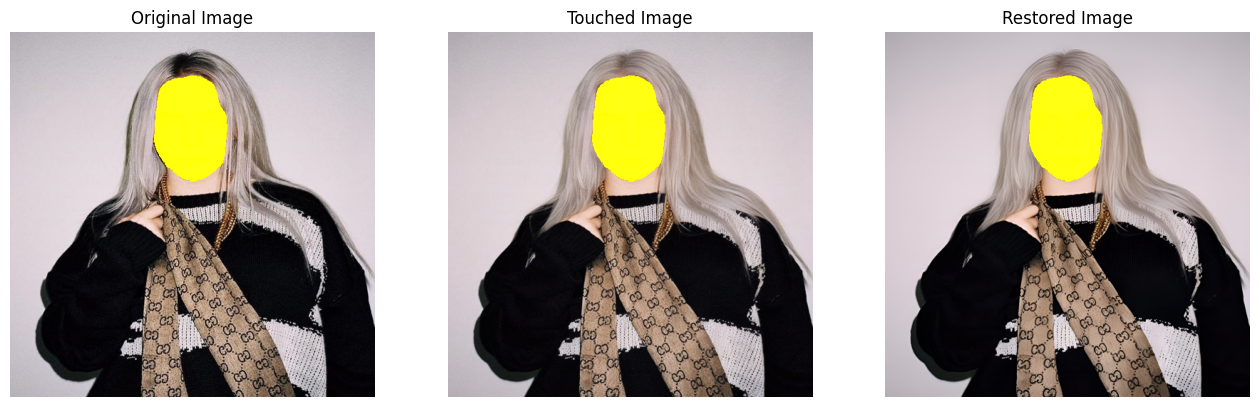

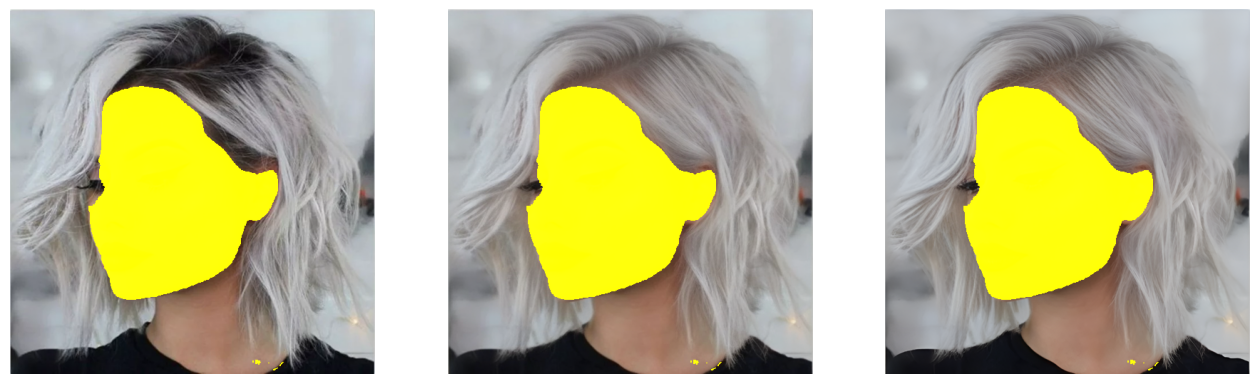

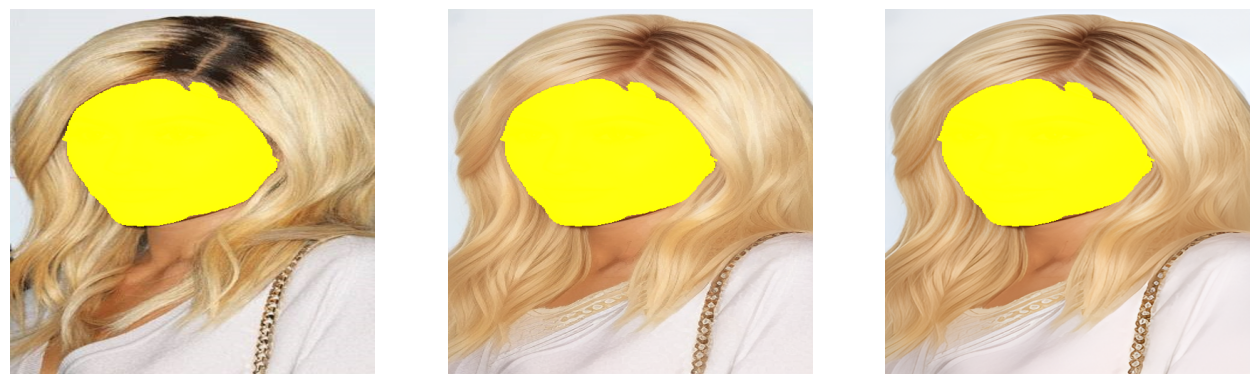

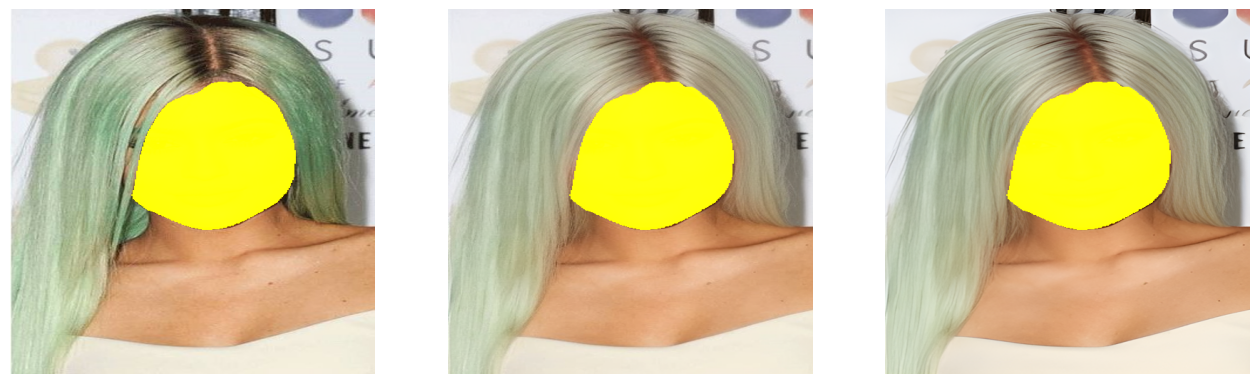

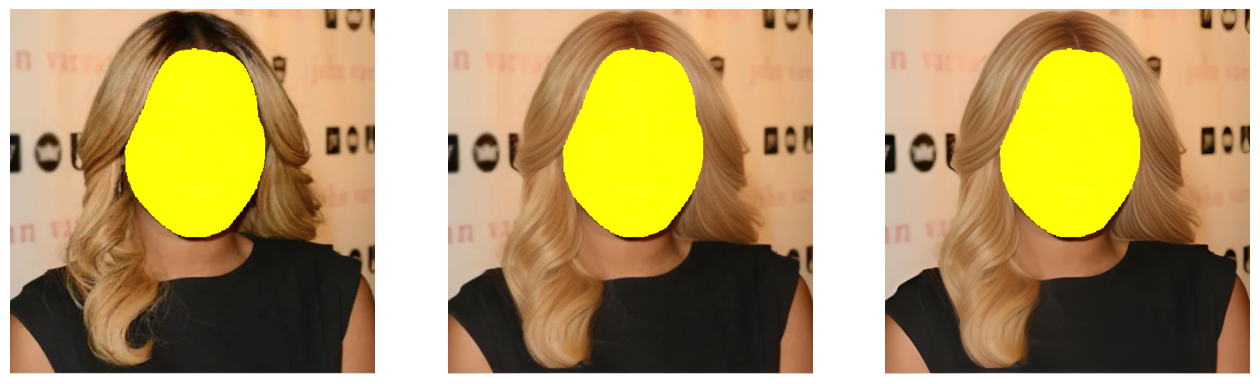

In [ ]:
demo_img_list = [1,19,21,22,32]
ReSize = (512,512)
img_titles = ["Original Image", "Touched Image", "Restored Image"]
if __name__ == "__main__":
  for n, i in enumerate(demo_img_list):
    fig, axes = plt.subplots(1, 3, figsize = (16,9))
    IMG_PATH =  os.path.join(project_dir_path,"input_dir", "pic" + str(i) + ".png")
    MINORITY_HAIR_MASK_PATH = os.path.join(project_dir_path, mask_dir_path,"pic" + str(i) + "_mask.png")
    TOUCHED_IMAGE_PATH = os.path.join(project_dir_path, touched_dir_path, "pic" + str(i) + "_touched.png")
    RESTORED_IMAGE_PATH = os.path.join(project_dir_path, restored_dir_path, "pic" + str(i) + "_restored.png")
    mask_generater = GenerateMask(IMG_PATH)
    face_mask = mask_generater.get_face_mask()
    image = Image.open(IMG_PATH)
    touched_image = Image.open(TOUCHED_IMAGE_PATH)
    restored_image = Image.open(RESTORED_IMAGE_PATH)
    img_list = [image.resize(ReSize), touched_image.resize(ReSize), restored_image.resize(ReSize)]
    for j, img_ in enumerate(img_list):
        img = apply_face_mask_overlay(img_,face_mask)

        axes[j].imshow(img)
        axes[j].axis('off')
        if n == 0:
          axes[j].set_title(img_titles[j])

    plt.show()


